In [1]:
 #!nvidia-smi

In [1]:
BATCH_SIZE = 16
MAX_LEN = 512
EPOCHS = 10
RANDOM_SEED = 42
model_name = 'bert-base-uncased'

In [2]:
from utils.cloudant_utils import cloudant_db as db
import numpy as np
import pandas as pd
from datetime import datetime
import difflib
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch import nn
from collections import defaultdict
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from readme_cleanup import readme_cleanup

SUCCESS connecting to Cloudant db github-public-ai-2022


In [3]:
repos = [r for r in db.get_query_result({"type": "release"}, ["_id", "releases"], limit=10000, raw_result=True)["docs"]]
values = [r for release in repos for r in release["releases"]]
df = pd.DataFrame(values)
df['contributors'] = df['contributors'].apply(lambda x:
                                              [i for i in x if i is not None] if isinstance(x, list)
                                              else [])
df = df[~df['readme'].isnull()]
new_df = df.groupby("repo").agg({"readme": list,
                                 "stars": sum,
                                 "forks": sum,
                                 "downloads": sum,
                                 "contributors": sum})
new_df['600stars']= np.where(new_df['stars'] > 600, 1, 0)
new_df = new_df[:100]

In [5]:
def diff_calculator(str1, str2):
   s = difflib.SequenceMatcher(lambda x : x == '')
   s.set_seqs(str1, str2)
   i = 1
   # codes = []
   # delete = []
   # replace = {}
   insert = []
   for (opcode, before_start, before_end, after_start, after_end) in s.get_opcodes():
       if opcode == 'equal':
           continue
       # codes.append(opcode)
       # # print (i, ". %7s '%s :'  ----->  '%s'" % (opcode, test[0][before_start:before_end], test[1][after_start:after_end]))
       # if opcode == 'replace':
       #     replace[str1[before_start:before_end]]  = str2[after_start:after_end]
       # if opcode == 'delete':
       #     delete.append(str1[before_start:before_end])
       if opcode == 'insert':
           if str2[after_start:after_end]:
            insert.append(str2[after_start:after_end])
       i = i + 1
   # return replace, delete, insert
   return insert

def create_a_sequence(readmeList):
    result = []
    for i in range(0,len(readmeList)-1):
        first = readme_cleanup(readmeList[i])
        second = readme_cleanup(readmeList[i+1])
        insert = diff_calculator(first, second)
        result.append(','.join(insert))
    return result

def prepareSequenceForBERT(readmeList):
    diffList = create_a_sequence(readmeList)
    s = '[CLS]' + "[SEP]".join([str(i) for i in diffList])
    return s +'[SEP]'

In [6]:

# len(new_df.iloc[1]['readme']), prepareSequenceForBERT(new_df.iloc[1]['readme'])

In [7]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

df_train, df_test = train_test_split(new_df, test_size=0.4, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((60, 6), (20, 6), (20, 6))

In [9]:
class ReadmeDataSet(Dataset):
   def __init__(self, _df, tokenizer, max_len):
      self._df = _df
      self.tokenizer = tokenizer
      self.max_len = max_len

   def __len__(self):
      return len(self._df)

   def __getitem__(self, item):
      _sequence = prepareSequenceForBERT(self._df.iloc[item]['readme'])
      target = self._df.iloc[item]['600stars']
      encoding = self.tokenizer.encode_plus(_sequence,
                                     None,
                                     max_length = self.max_len,
                                     truncation=True,
                                     add_special_tokens=True,
#                                      padding=MAX_LEN,
#                                      padding='longest',
                                     pad_to_max_length=True,
                                     return_token_type_ids=True)

      return {
      'sequence': _sequence,
      'input_ids': torch.tensor(encoding.input_ids, dtype=torch.long),
      'attention_mask':  torch.tensor(encoding.attention_mask, dtype=torch.long),
      'token_type_ids': torch.tensor(encoding.token_type_ids, dtype=torch.long),
      'targets': torch.tensor(target, dtype=torch.long)
      }

In [10]:
def create_data_loader(_df, tokenizer, max_len, batch_size):
   ds = ReadmeDataSet(_df = _df, tokenizer=tokenizer, max_len=max_len)
   return DataLoader(ds, batch_size=batch_size, num_workers=0)

Import BERT Tokenizer and BERT Model

In [16]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=2,
                                                      output_attentions= False,
                                                      output_hidden_states= False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [18]:
read_me_list = new_df['readme'].tolist()
# read_me_list

In [20]:
max_len = 0
for sentences in read_me_list:
    for sent in sentences:
        if sent:
            input_ids = bert_tokenizer.encode(sent, add_special_tokens=True)
            max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  31456


In [16]:
sample = df[:10]
X = sample.apply(lambda row : prepareSequenceForBERT(row['readme']), axis = 1)
X

1     [CLS][SEP]M[SEP][SEP][SEP][SEP][SEP][SEP][SEP]...
2     [CLS][SEP]S[SEP][SEP][SEP][SEP][SEP][SEP][SEP]...
3     [CLS][SEP][SEP]K[SEP][SEP][SEP][SEP][SEP][SEP]...
4     [CLS][SEP]![SEP][SEP][SEP][SEP][SEP][SEP][SEP]...
5     [CLS][SEP]![SEP][SEP][SEP][SEP][SEP][SEP][SEP]...
6     [CLS][SEP]![SEP][SEP][SEP][SEP][SEP][SEP][SEP]...
7     [CLS][SEP]![SEP][SEP][SEP][SEP][SEP][SEP][SEP]...
8     [CLS][SEP]![SEP][SEP][SEP][SEP][SEP][SEP][SEP]...
9     [CLS][SEP]![SEP][SEP][SEP][SEP][SEP][SEP][SEP]...
10    [CLS][SEP]![SEP][SEP][SEP][SEP][SEP][SEP][SEP]...
dtype: object

In [12]:
inputDS = ReadmeDataSet(df, bert_tokenizer, 512)
df['cleanreadme'] = df.apply(lambda row : prepareSequenceForBERT(row['readme']), axis = 1)
X = df['cleanreadme']
X.shape

TypeError: Cannot index by location index with a non-integer key

In [17]:
import lda
model = lda.LDA(n_topics=20, n_iter=1500, random_state=1)
model.fit(X)

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
topic_word = model.topic_word_
n_top_words = 8
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(X)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

In [12]:
train_data_loader = create_data_loader(df_train, bert_tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, bert_tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, bert_tokenizer, MAX_LEN, BATCH_SIZE)
new_df.shape, df_train.shape, df_val.shape, df_test.shape

((100, 6), (60, 6), (20, 6), (20, 6))

In [13]:
# for d in train_data_loader:
#     input_ids = d["input_ids"].to(device)
#     attention_mask = d["attention_mask"].to(device)
#     targets = d["targets"].to(device)
#     print(d["input_ids"].shape)
# len(val_data_loader.dataset)

In [14]:
# TEST the tokenizer and data loader
# sequence = prepareSequenceForBERT(new_df.iloc[1]['readme'])
# label = new_df.iloc[2]['600stars']
# tokens = bert_tokenizer.encode_plus(
#             sequence,
#             None,
#             max_length= 512,
#             truncation=True,
#             add_special_tokens=True,
# #             pad_to_max_length=True,
#             padding = True,
#             return_token_type_ids=True
#         )
# print(f' Sentence: {sequence}')
# print(f' Tokens: {tokens}')
# print(f' Tokens.token_type_ids: {tokens.token_type_ids}')
# print(f' Tokens.input_ids: {len(tokens.input_ids)}')
# output = {
#       'input_ids': torch.tensor(tokens.input_ids, dtype=torch.long),
#       'attention_mask':  torch.tensor(tokens.attention_mask, dtype=torch.long),
#       'token_type_ids': torch.tensor(tokens.token_type_ids, dtype=torch.long),
#       'targets': torch.tensor(label, dtype=torch.long)
#     }
# output

In [15]:
optimizer = AdamW(bert_model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

from transformers import get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
# loss_fn = nn.CrossEntropyLoss().to(device)

/Users/julinamaharjan/PycharmProjects/github-crawler/env/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
def train_epoch( model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs.logits, dim=1)
    loss = loss_fn(outputs.logits, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [17]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs.logits, dim=1)

      loss = loss_fn(outputs.logits, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [18]:
%%time
history = defaultdict(list)
loss_fn = nn.CrossEntropyLoss().to(device)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    bert_model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    bert_model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    current_time = datetime.now().strftime("%Y_%m_%d-%I_%M%p")
    torch.save(bert_model.state_dict(), 'best_model_state' + current_time+'.bin')
    best_accuracy = val_acc

/Users/julinamaharjan/PycharmProjects/github-crawler/env/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/10
----------
Train loss 0.3004196286201477 accuracy 0.9166666666666666
Val   loss 0.13683850690722466 accuracy 0.95

Epoch 3/10
----------
Train loss 0.18011835310608149 accuracy 0.9333333333333333
Val   loss 0.14710313826799393 accuracy 0.95

Epoch 4/10
----------
Train loss 0.130374850705266 accuracy 0.9333333333333333
Val   loss 0.12100890278816223 accuracy 0.95

Epoch 5/10
----------
Train loss 0.10133744310587645 accuracy 0.9333333333333333
Val   loss 0.10634927451610565 accuracy 0.95

Epoch 6/10
----------
Train loss 0.07862597063649446 accuracy 0.95
Val   loss 0.1610282063484192 accuracy 0.95

Epoch 7/10
----------
Train loss 0.06008679635124281 accuracy 0.95
Val   loss 0.1485648863017559 accuracy 0.95

Epoch 8/10
----------
Train loss 0.049081339995609596 accuracy 0.95
Val   loss 0.12847472727298737 accuracy 0.95

Epoch 9/10
----------
Train loss 0.050877975969342515 accuracy 0.95
Val   loss 0.12819460593163967 accuracy 0.95

Epoch 10/10
----------
Train loss 0.0404199

In [19]:
test_acc, _ = eval_model(bert_model, test_data_loader, loss_fn, device, len(df_test))
test_acc.item()

1.0

In [20]:
def get_predictions(model, data_loader):
  model = model.eval()

  sequences = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["sequence"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

      _, preds = torch.max(outputs.logits, dim=1)
      probs = F.softmax(outputs.logits, dim=1)

      sequences.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return outputs, sequences, predictions, prediction_probs, real_values

In [31]:
outputss, y_sequences, y_pred, y_pred_probs, y_test = get_predictions(bert_model, val_data_loader)

/Users/julinamaharjan/PycharmProjects/github-crawler/env/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


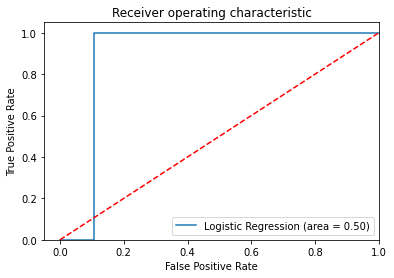

In [32]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test.numpy(), y_pred_probs[:, 1:].numpy())
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC_'+ current_time +'.png')
plt.show()

In [33]:
fpr, tpr, thresholds

(array([0.        , 0.05263158, 0.10526316, 0.10526316, 0.63157895,
        0.78947368, 1.        ]),
 array([0., 0., 0., 1., 1., 1., 1.]),
 array([1.21246111e+00, 2.12461069e-01, 1.02780305e-01, 3.57354097e-02,
        7.61162606e-04, 7.33732188e-04, 7.33731838e-04], dtype=float32))

In [34]:
y_pred_probs_pd = [y.numpy() for y in y_pred_probs]
someListOfLists = list(zip(y_sequences, y_test.numpy(), y_pred.numpy(), y_pred_probs[:, 1:].numpy().squeeze(), y_pred_probs_pd ))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['readme', 'Real', 'Predicted', 'Pred-prob', 'All Pred-probs' ])
dff

/var/folders/xq/pylr4t8d08g_cywhg3hhf02w0000gn/T/ipykernel_72783/2889840059.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  npa = np.asarray(someListOfLists)


,readme,Real,Predicted,Pred-prob,All Pred-probs
0,"[CLS]Install with Docker\n,directly in the con...",0,0,0.002230,"[0.99776983, 0.002230199]"
1,[CLS]EvenVizion - is a video-based camera loca...,0,0,0.001103,"[0.9988971, 0.0011029042]"
2,[CLS][SEP],0,0,0.000734,"[0.9992662, 0.00073373184]"
3,[CLS][SEP],0,0,0.000734,"[0.9992662, 0.0007337322]"
4,[CLS][SEP],0,0,0.000734,"[0.9992662, 0.00073373184]"
5,[CLS][SEP][SEP][SEP]⚓ Citation\nPlease use the...,0,0,0.000761,"[0.99923885, 0.0007611626]"
6,"[CLS] ,\ntry a another image (mirror.baidubce....",1,0,0.035735,"[0.9642646, 0.03573541]"
7,[CLS][SEP],0,0,0.000734,"[0.9992662, 0.0007337322]"
8,[CLS][SEP][SEP][SEP],0,0,0.000771,"[0.9992292, 0.0007707568]"
9,[CLS]\nInstallation\nClone the repo\nInstall r...,0,0,0.212461,"[0.78753895, 0.21246107]"
